In [1]:
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import scanpy as sc
from scipy.sparse import csr_matrix
import diffxpy.api as de
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
print("Reading!")
adata = sc.read("./dataSaveOriginal/rawDataset5000.h5ad") # ./dataSaveOriginal/rawDataset5000.h5ad
adata.var_names_make_unique()

genesHSA21 = pd.read_csv("./dataSaveOriginal/HSA21genes.csv")
genesHSA21List = []

for gene in genesHSA21["hgnc_symbol"].tolist():
    if type(gene) == str:
        genesHSA21List.append(gene)

adata.X = adata.raw.X

adata.X = csr_matrix(adata.X)
print("To Dense!")
adata.X = adata.X.todense()

print(adata.obs)
adata.obs = adata.obs.rename(columns = {'group':'condition'})
print(adata.obs)

print("Data!")
data = anndata.AnnData(
    X=adata.X,
    var=adata.var,
    obs=adata.obs
)
data.var_names_make_unique()

print("Highly Variable Genes!")
sc.pp.highly_variable_genes(data, n_top_genes=10000, subset = True, flavor = "seurat_v3", batch_key="sample")


print("Wald Test!")
test = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
)
sumar = test.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)
sumar['log2fc'] = sumar['log2fc']*-1
sumar = sumar.sort_values('log2fc', ascending = False).reset_index(drop = True)
sumar = sumar[(sumar.qval < 0.05) & (abs(sumar.log2fc) > .5)]
sumar = sumar[sumar['mean'] > 0.15]

sumar.to_csv("./diffxpyLogs.csv")

genes_to_show = sumar[-25:].gene.tolist() + sumar[:25].gene.tolist() #top 25 and bottom 25 from sorted df

print(len(genes_to_show))


Reading!
To Dense!
                            orig.ident  nCount_RNA  nFeature_RNA group  \
DS_DSP_GACCTTCCACAGTACT-1           DS     16399.0          5286    DS   
CON_IMR_GTGATGTGTCAACGCC-1         CON      1271.0           849   CON   
DS_DS1_GTCGCGAAGAGTGTTA-1           DS      5905.0          2729    DS   
CON_DS2U_GCTCAAACAAAGGCGT-1        CON      7464.0          3107   CON   
DS_2DS3_TAAGCACCACATTCGA-1          DS     13943.0          5018    DS   
...                                ...         ...           ...   ...   
DS_DS1_AGGGTGAGTCCGAAAG-1           DS     57452.0          9447    DS   
CON_IMR_GTGTGGCCAAATTGCC-1         CON      3836.0          2240   CON   
CON_DS2U_CCTCAACAGCGAAACC-1        CON      6881.0          3506   CON   
CON_IMR_GTCCTCAAGGTTAAAC-1         CON      4583.0          2577   CON   
CON_DS2U_GACAGCCTCGTTAGTG-1        CON      7909.0          3597   CON   

                               sample  percentMito  percent_reads_top50  \
DS_DSP_GACCTTCCAC

/var/folders/f2/tr4hpwss57b952qwypb78gb40000gn/T/ipykernel_2361/543229270.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(


Highly Variable Genes!
Wald Test!
training location model: False
training scale model: True
iter   0: ll=26409389.946653
iter   1: ll=26409389.946653, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=26279382.209388, converged: 0.11% (loc: 0.11%, scale update: True), in 29.03sec
iter   3: ll=26279382.209388, converged: 0.11% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=26278106.509638, converged: 99.95% (loc: 99.95%, scale update: True), in 30.27sec
iter   5: ll=26278106.509638, converged: 99.95% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=26278106.509638, converged: 100.00% (loc: 100.00%, scale update: True), in 5.03sec


/opt/homebrew/lib/python3.10/site-packages/dask/array/core.py:3062: RuntimeWarning: divide by zero encountered in divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


50


In [47]:
sumar

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
43,GNRH1,0.0,0.0,5.841243,1.9226,False,1.288790e-08,-5.841243,0.283445,-1939.240177
68,AL583808.1,0.0,0.0,1.891461,0.1652,False,6.880198e-09,-1.891461,0.177367,-1536.661564
90,NDST3,0.0,0.0,1.648716,0.8528,False,3.133363e-08,-1.648716,0.101232,-4327.188807
99,AC009264.1,0.0,0.0,1.593087,0.2080,False,1.003594e-09,-1.593087,0.177844,-1663.451593
117,KHDRBS3,0.0,0.0,1.475656,0.6940,False,1.116846e-09,-1.475656,0.069724,-4978.332936
...,...,...,...,...,...,...,...,...,...,...
9932,NECTIN3-AS1,0.0,0.0,-2.869258,0.9192,False,7.189332e-10,2.869258,0.142670,-2928.171022
9935,APOE,0.0,0.0,-2.924756,0.7570,False,3.117287e-08,2.924756,0.124426,-3212.635272
9942,COLEC12,0.0,0.0,-3.403005,0.1990,False,2.074020e-11,3.403005,0.227279,-1326.447937
9948,PAX3,0.0,0.0,-3.903203,0.2884,False,3.284188e-09,3.903203,0.215622,-1745.807070


<AxesSubplot: ylabel='gene'>

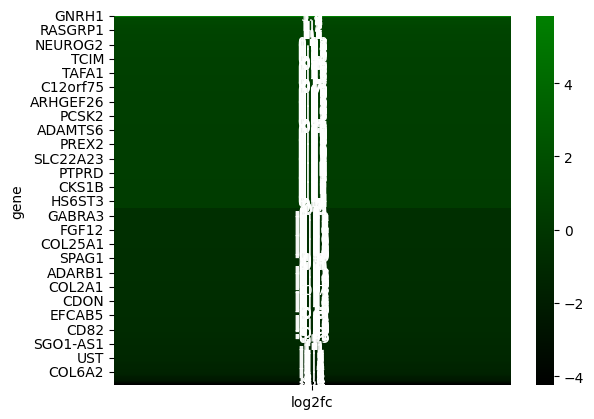

In [55]:
pandasSumar = pd.DataFrame(columns=["gene", "log2fc"])
pandasSumar["gene"] = sumar["gene"]
pandasSumar["log2fc"] = sumar["log2fc"]
pandasSumar = pandasSumar.set_index('gene')
pandasSumar
sns.heatmap(pandasSumar, annot=True, cmap=sns.blend_palette(["black", "green"], as_cmap=True))

<class 'tuple'>
['HUNK', 'COL6A1', 'COL6A2', 'TMEM50B', 'DOP1B', 'CXADR', 'BTG3', 'CHODL', 'TMPRSS15', 'NCAM2', 'JAM2', 'GABPA', 'ADAMTS1', 'ADAMTS5', 'SAMSN1', 'USP25', 'RWDD2B', 'TIAM1', 'SCAF4', 'KCNJ6', 'ERG', 'LCA5L', 'MX1', 'MIS18A', 'CFAP298', 'IFNAR2', 'RCAN1', 'RUNX1', 'CBR3', 'CHAF1B', 'SIM2', 'HLCS', 'ABCG1', 'RSPH1', 'SLC37A1', 'PKNOX1', 'HSF2BP', 'CSTB', 'AGPAT3', 'FTCD', 'C21orf58', 'PCNT', 'S100B', 'CYYR1', 'EVA1C', 'MRAP', 'GRIK1', 'DSCAM', 'DNAJC28', 'KCNE1', 'NRIP1', 'BACE2', 'TTC3', 'COL18A1', 'PCP4', 'IGSF5', 'RIPPLY3', 'PTTG1IP', 'MX2', 'PSMG1', 'PCBP3', 'B3GALT5', 'OLIG1', 'ADARB1', 'SLC5A3', 'LTN1', 'C21orf62', 'ERVH48-1', 'TCP10L', 'MRPS6']
70


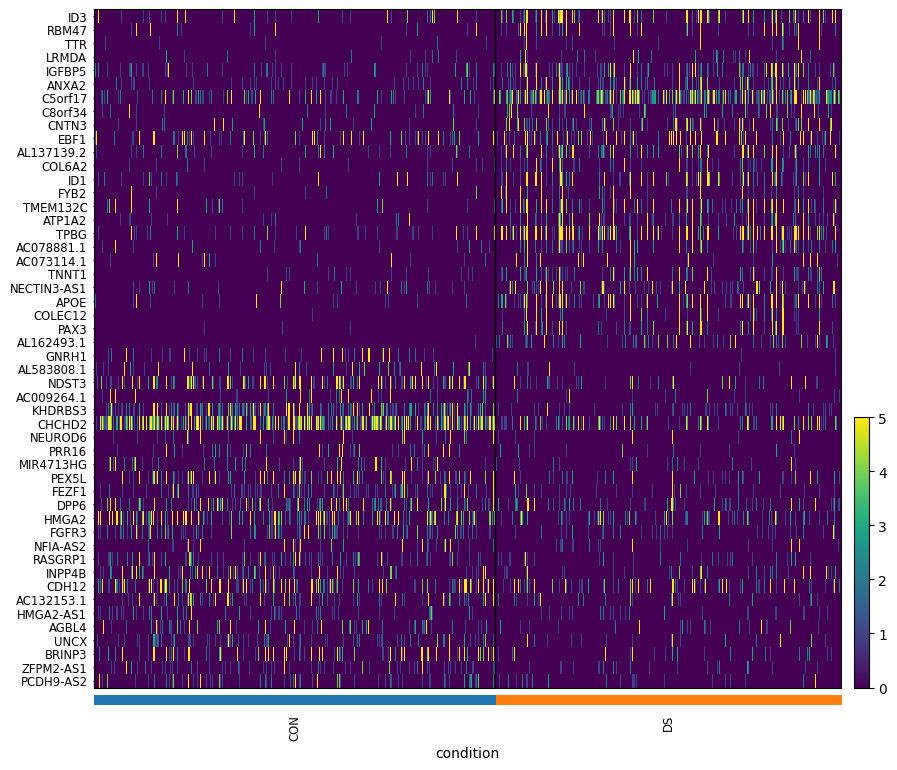

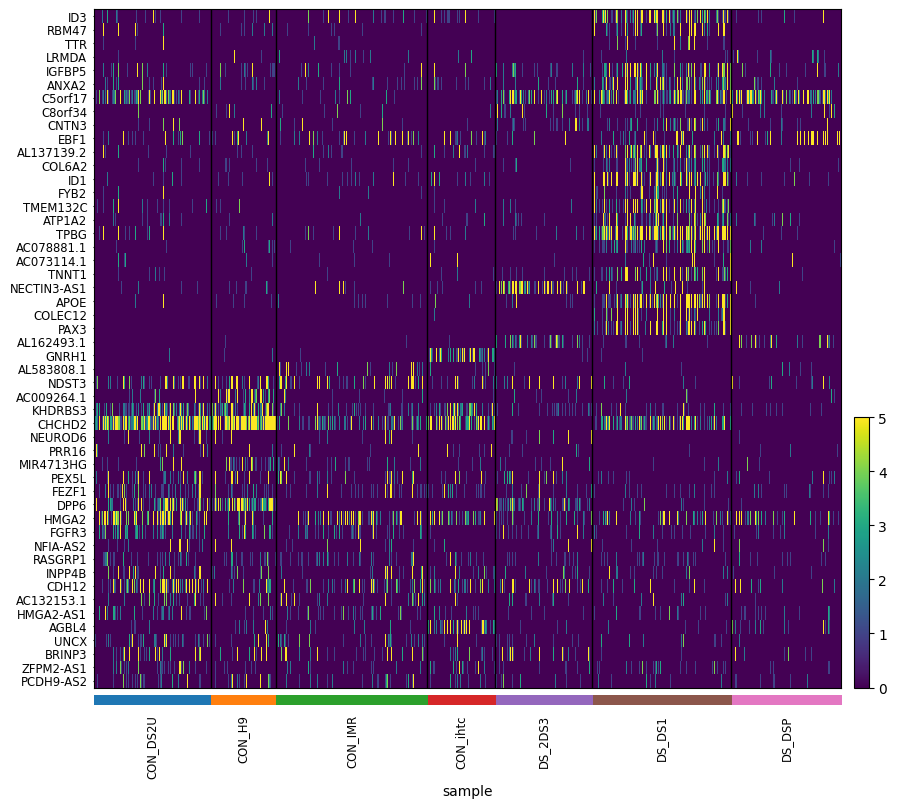

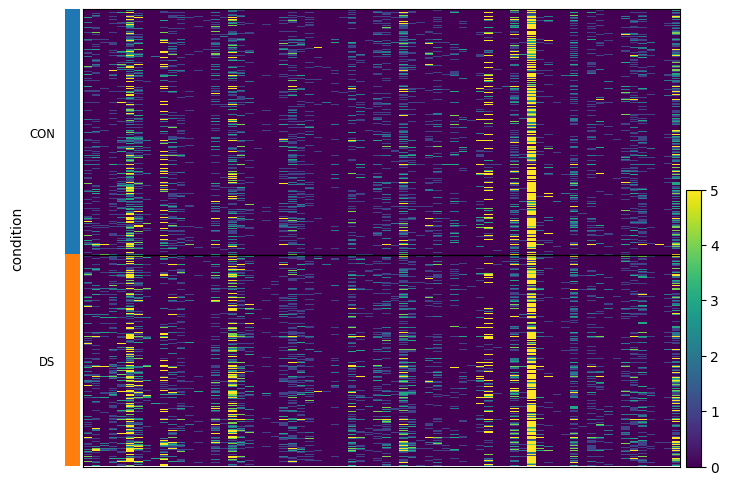

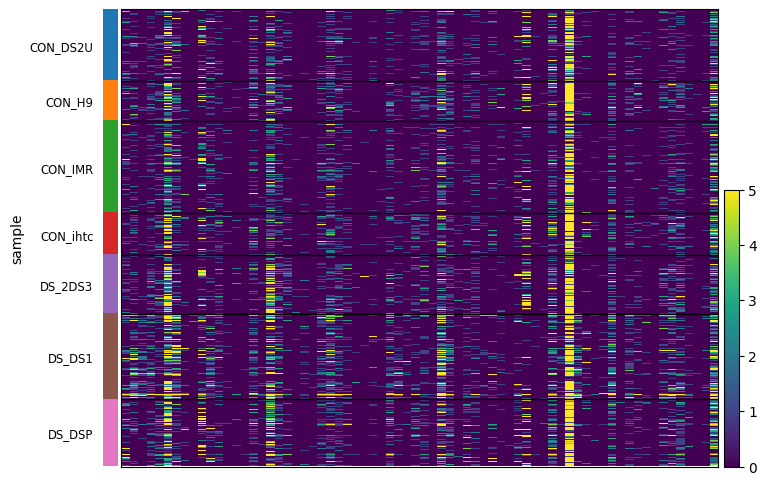

In [37]:
import ast
sc.pl.heatmap(data, genes_to_show, groupby='condition', vmax=5, swap_axes=True, show=False)
sc.pl.heatmap(data, genes_to_show, groupby='sample', vmax=5, swap_axes=True, show=False)
try:
    sc.pl.heatmap(data, genesHSA21List, groupby="condition", vmax=5, show=False)
    sc.pl.heatmap(data, genesHSA21List, groupby="sample", vmax=5, show=False)

except Exception as e:
    print(type(e.args))

    errorMessage = str(e.args[0])
    errorMessage = errorMessage.replace("Could not find keys '", "")
    errorMessage = errorMessage.replace("' in columns of `adata.obs` or in adata.var_names.", "")

    errorMessage = ast.literal_eval(errorMessage)
    new_list = [fruit for fruit in genesHSA21List if fruit not in errorMessage]
    print(new_list)
    print(len(new_list))
    sc.pl.heatmap(data, new_list, groupby="condition", vmax=5, show=False)
    sc.pl.heatmap(data, new_list, groupby="sample", vmax=5, show=False)

